# Part 3: Visualization Implementations

This notebook contains all three visualizations for Part 3 of the data visualization project.

- **Viz1**: Interactive Temporal Crime Patterns Heatmap
- **Viz2**: Monthly Crime Trends by Type (Small Multiples)
- **Viz3**: Crime Hotspot Map (Geographic - Non-Cartesian)


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

# Load data
df = pd.read_csv('data/Crimes_-_2001_to_Present_20251118.csv')

# Parse dates
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df = df.dropna(subset=['Date'])

print(f"Data loaded: {len(df)} records")


Data loaded: 258077 records


## Viz1: Interactive Temporal Crime Patterns Heatmap


In [43]:
# Extract hour and day of week
df['hour'] = df['Date'].dt.hour
df['dayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0
df['primaryType'] = df['Primary Type']

# Get crime types for filter
crime_types = sorted(df['primaryType'].unique().tolist())
print(f"Crime types: {len(crime_types)}")


Crime types: 31


interactive(children=(Dropdown(description='Crime Type:', layout=Layout(width='300px'), options=('All', 'ARSON…


Saving static visualization...


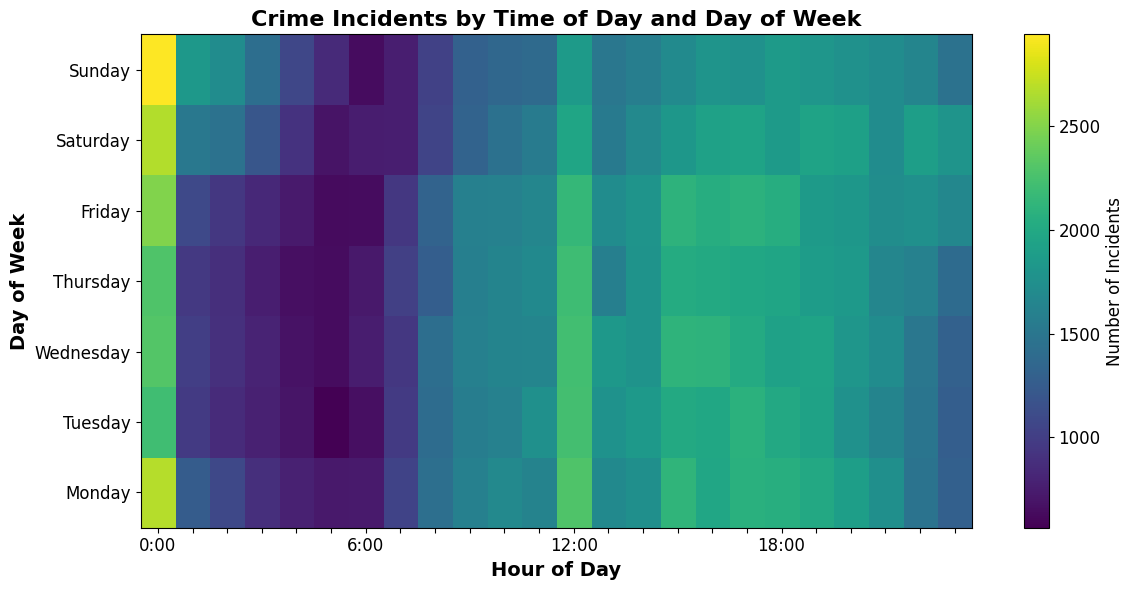

Saved: viz1.png and viz1.svg


In [ ]:
# Create interactive heatmap using ipywidgets and matplotlib
try:
    from ipywidgets import interact, widgets
    import matplotlib.colors as mcolors
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("Note: ipywidgets not available. Showing static visualization.")

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def create_heatmap(crime_type='All'):
    # Filter data
    if crime_type == 'All':
        filtered_data = df
        title_suffix = ''
    else:
        filtered_data = df[df['primaryType'] == crime_type]
        title_suffix = f' - {crime_type}'
    
    # Aggregate by day of week and hour
    heatmap = filtered_data.groupby(['dayOfWeek', 'hour']).size().reset_index(name='count')
    
    # Create pivot table
    pivot = heatmap.pivot(index='dayOfWeek', columns='hour', values='count').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Use viridis colormap (color-blind safe)
    im = ax.imshow(pivot.values, cmap='viridis', aspect='auto', origin='lower')
    
    # Set ticks and labels
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h}:00' if h % 6 == 0 else '' for h in range(24)], fontsize=12)
    ax.set_yticks(range(7))
    ax.set_yticklabels(days, fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Number of Incidents', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Labels and title
    ax.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
    ax.set_ylabel('Day of Week', fontsize=14, fontweight='bold')
    ax.set_title(f'Crime Incidents by Time of Day and Day of Week{title_suffix}', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('viz1.png', dpi=300, bbox_inches='tight')
    # plt.savefig('viz1.svg', bbox_inches='tight')
    
    plt.show()

# Create interactive widget or show static version
if WIDGETS_AVAILABLE:
    crime_type_options = ['All'] + sorted(crime_types[:20])  # Top 20 for performance
    
    dropdown = widgets.Dropdown(
        options=crime_type_options, 
        value='All', 
        description='Crime Type:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    interact(create_heatmap, crime_type=dropdown)
else:
    # Fallback: show static version
    create_heatmap('All')
    print("\nTo enable interactivity, install ipywidgets: pip install ipywidgets")
    print("Then restart Jupyter and enable the extension: jupyter nbextension enable --py widgetsnbextension")

# Also save a static version for export
print("\nSaving static visualization...")
create_heatmap('All')
print("Saved: viz1.png and viz1.svg")


### Alternative: Static Heatmap (if widgets don't work)

If the interactive widget above doesn't display, here's a static version showing all crime types:


## Viz2: Monthly Crime Trends by Type (Small Multiples)


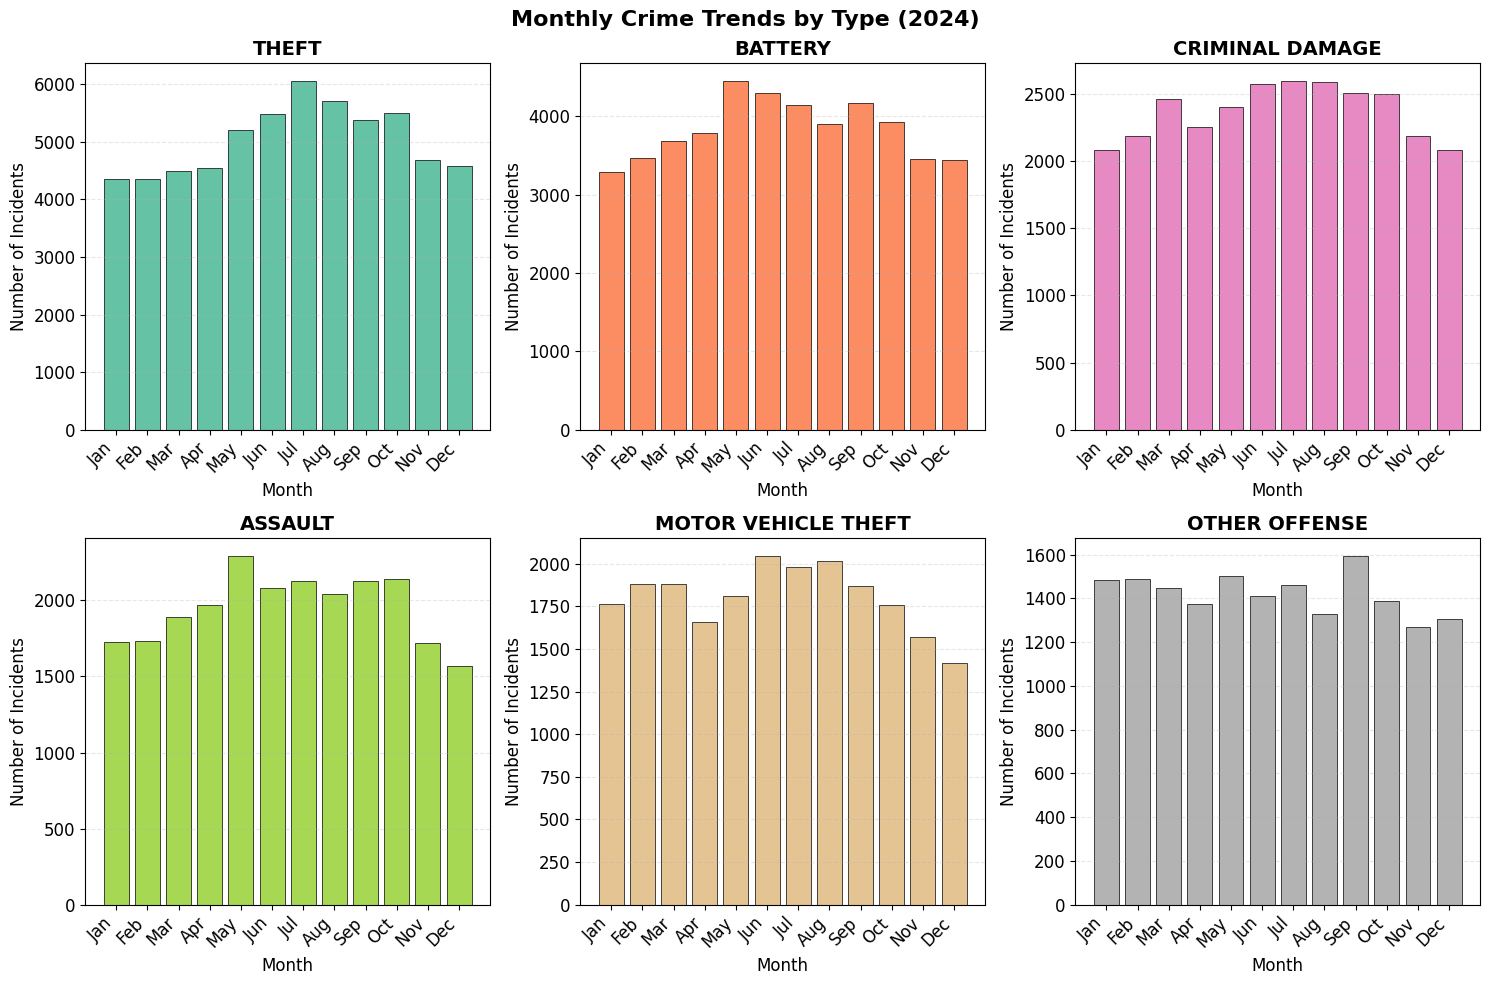

In [ ]:
# Extract month
df['Month'] = df['Date'].dt.month

# Get top 6 crime types
top_crimes = df['Primary Type'].value_counts().head(6).index.tolist()
df_filtered = df[df['Primary Type'].isin(top_crimes)]

# Aggregate by month and crime type
monthly_counts = df_filtered.groupby(['Month', 'Primary Type']).size().reset_index(name='Count')
monthly_counts = monthly_counts.sort_values(['Month', 'Primary Type'])

# Create small multiples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Monthly Crime Trends by Type (2024)', fontsize=16, fontweight='bold')

# Color-blind safe palette
colors = plt.cm.Set2(np.linspace(0, 1, 6))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for idx, crime_type in enumerate(top_crimes):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    crime_data = monthly_counts[monthly_counts['Primary Type'] == crime_type]
    
    # Ensure all months are represented
    month_data = []
    for month in month_order:
        month_row = crime_data[crime_data['Month'] == month]
        if len(month_row) > 0:
            month_data.append(month_row.iloc[0]['Count'])
        else:
            month_data.append(0)
    
    bars = ax.bar(month_names, month_data, color=colors[idx], edgecolor='black', linewidth=0.5)
    ax.set_title(crime_type, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Number of Incidents', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Rotate x-axis labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

# Save figure
plt.savefig('viz2.png', dpi=300, bbox_inches='tight')
# plt.savefig('viz2.svg', bbox_inches='tight')

plt.show()


## Viz3: Crime Hotspot Map (Geographic)


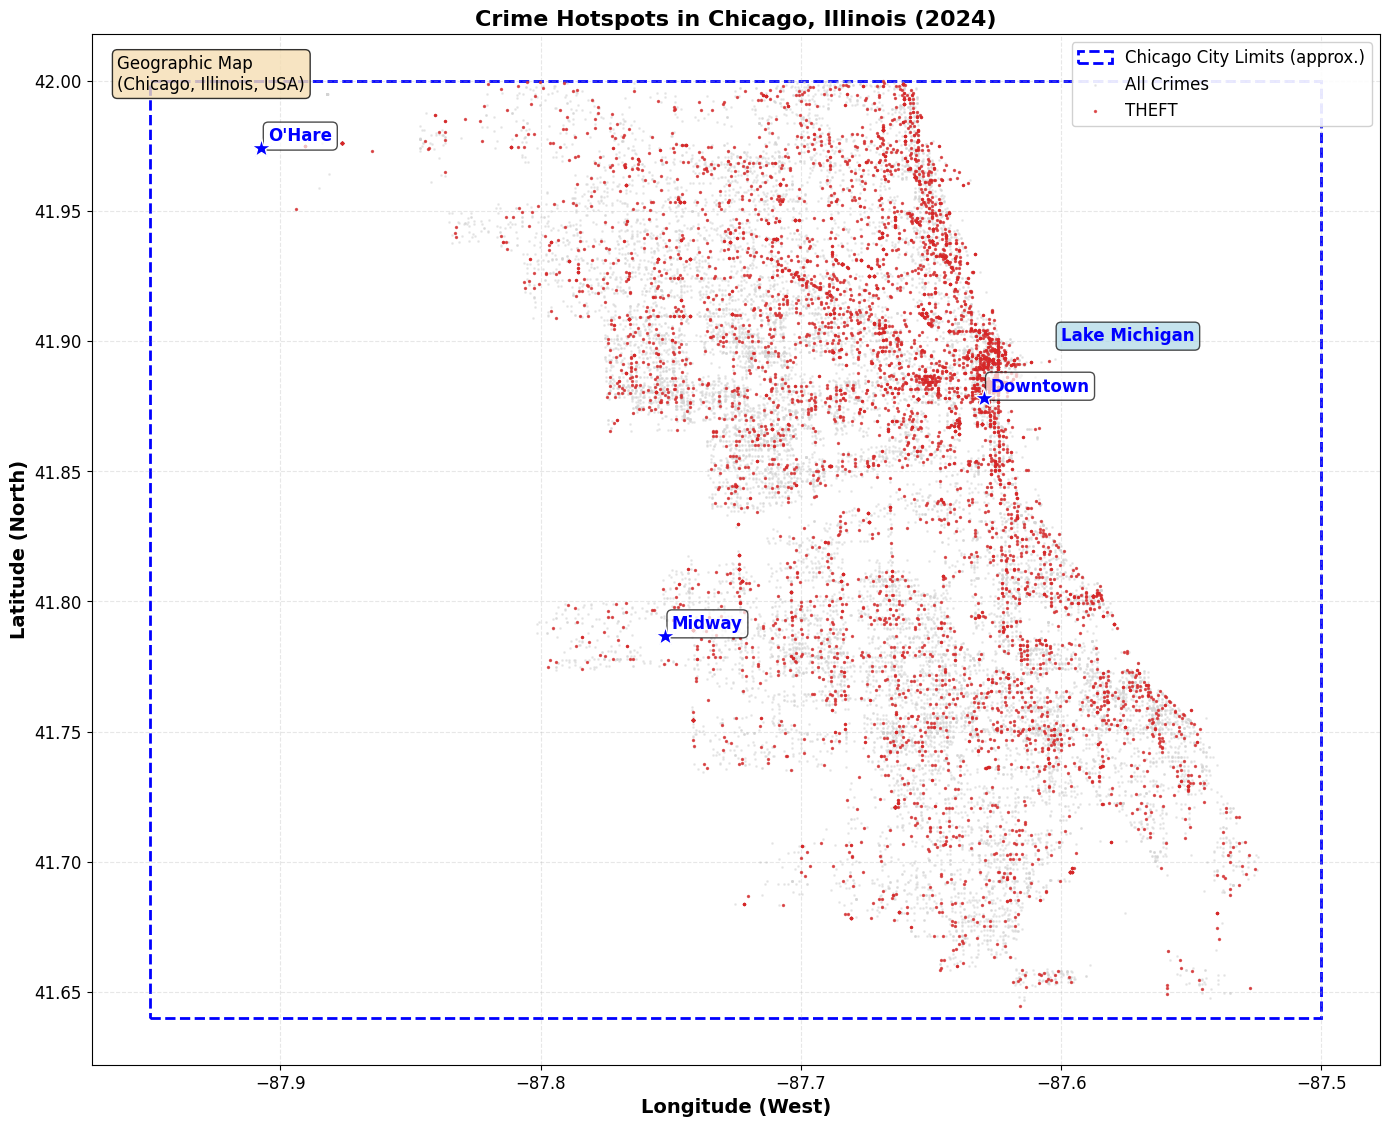

Displaying 25,070 crime locations (sampled from 250,697 with valid coordinates)
Top crime type: THEFT (5,855 incidents shown in red)


In [ ]:
# Filter to records with valid coordinates
df_coords = df[(df['Latitude'].notna()) & (df['Longitude'].notna())].copy()

# Filter to Chicago bounds (41.6-42.0°N, -87.9 to -87.5°W)
chicago_bounds = (
    (df_coords['Latitude'] >= 41.6) & (df_coords['Latitude'] <= 42.0) &
    (df_coords['Longitude'] >= -87.9) & (df_coords['Longitude'] <= -87.5)
)
df_coords = df_coords[chicago_bounds]

# Sample for performance (use every 10th point for visualization)
df_sample = df_coords.iloc[::10].copy()

# Get top crime type for color coding
top_crime = df['Primary Type'].value_counts().index[0]
df_sample['is_top_crime'] = df_sample['Primary Type'] == top_crime

# Create geographic scatter plot (non-cartesian - uses lat/lon coordinates)
fig, ax = plt.subplots(figsize=(14, 12))

# Chicago approximate boundaries for reference
chicago_lat_center = 41.8781
chicago_lon_center = -87.6298

# Add reference box showing Chicago city limits (approximate)
chicago_box = mpatches.Rectangle((-87.95, 41.64), 0.45, 0.36, 
                           fill=False, edgecolor='blue', linewidth=2, linestyle='--', 
                           label='Chicago City Limits (approx.)')
ax.add_patch(chicago_box)

# Add reference points for major landmarks
landmarks = {
    'Downtown': (-87.6298, 41.8781),
    'O\'Hare': (-87.9073, 41.9742),
    'Midway': (-87.7522, 41.7868),
    'Lake Michigan': (-87.6, 41.9)
}

# Plot landmarks
for name, (lon, lat) in landmarks.items():
    if name != 'Lake Michigan':  # Don't plot lake as point
        ax.plot(lon, lat, marker='*', markersize=15, color='blue', 
               markeredgecolor='white', markeredgewidth=1, zorder=10)
        ax.annotate(name, (lon, lat), xytext=(5, 5), textcoords='offset points',
                   fontsize=12, fontweight='bold', color='blue',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add text annotation for Lake Michigan
ax.annotate('Lake Michigan', landmarks['Lake Michigan'], 
          fontsize=12, fontweight='bold', color='blue',
          bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# Plot all crimes in light gray
ax.scatter(df_sample['Longitude'], df_sample['Latitude'], 
           c='lightgray', s=1, alpha=0.4, label='All Crimes', rasterized=True, zorder=1)

# Highlight top crime type
top_crime_data = df_sample[df_sample['is_top_crime']]
if len(top_crime_data) > 0:
    ax.scatter(top_crime_data['Longitude'], top_crime_data['Latitude'],
               c='#d62728', s=2, alpha=0.7, label=f'{top_crime}', rasterized=True, zorder=2)

# Add grid with geographic context
ax.grid(alpha=0.3, linestyle='--', zorder=0)

# Labels and formatting
ax.set_xlabel('Longitude (West)', fontsize=14, fontweight='bold')
ax.set_ylabel('Latitude (North)', fontsize=14, fontweight='bold')
ax.set_title('Crime Hotspots in Chicago, Illinois (2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
ax.tick_params(labelsize=12)

# Set equal aspect ratio for geographic accuracy
ax.set_aspect('equal', adjustable='box')

# Add text annotation for geographic context
ax.text(0.02, 0.98, 'Geographic Map\n(Chicago, Illinois, USA)', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()

# Save figure
plt.savefig('viz3.png', dpi=300, bbox_inches='tight')
# plt.savefig('viz3.svg', bbox_inches='tight')

plt.show()

print(f"Displaying {len(df_sample):,} crime locations (sampled from {len(df_coords):,} with valid coordinates)")
print(f"Top crime type: {top_crime} ({len(top_crime_data):,} incidents shown in red)")
